## Importing the Data


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

#print(train_labels)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data = train_data.numpy()
test_data = test_data.numpy()

#train_labels = train_labels.reshape(train_labels.shape[0], 1)
#test_labels = test_labels.reshape(test_labels.shape[0], 1)


# Creating and Training the model

In [23]:
# Claim models
import keras
import matplotlib.pyplot as plt
import time

# The input size/image
input_img = keras.Input(shape=(train_data.shape[1],))
# The size of latent space
encoding_dim = 64
## Add a simple encode layer
batchSize = 32

activationAlg = "softmax"

data = []

for count in range(20):
  startTime = time.process_time()
  # encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)
  # You can add encode layer with a L1 activity regularizer
  encoded = keras.layers.Dense(encoding_dim, activation=activationAlg, 
                  activity_regularizer=keras.regularizers.l1(10e-5))(input_img)
  # Add decode layer
  decoded = keras.layers.Dense(train_data.shape[1], activation=activationAlg)(encoded)

  # Claim autoencoder model
  model_autoencoder = keras.Model(input_img, decoded)

  # Claim a separate encoder model
  model_encoder = keras.Model(input_img, encoded)

  # Claim a separate decoder model
  decoder_input = keras.Input(shape=(encoding_dim,))
  # Retrieve the last layer of the autoencoder model
  decoder_layer = model_autoencoder.layers[-1]
  # Create the decoder model
  model_decoder = keras.Model(decoder_input, decoder_layer(decoder_input))

  model = keras.Sequential()
  model.add(model_encoder.layers[0])
  model.add(model_encoder.layers[1])
  model.add(keras.layers.Dense(2, activation=activationAlg))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # Convert labels to categorical one-hot encoding
  one_hot_labels = keras.utils.to_categorical(train_labels, num_classes=2)

  # Train the model, iterating on the data in batches of 32 samples
  progress = model.fit(train_data, one_hot_labels, epochs=30, batch_size=batchSize)
  losses = progress.history['loss']

  y_pred_train=np.argmax(model.predict(train_data), axis=1)
  mse = mean_squared_error(train_labels,y_pred_train)
  timePassed = time.process_time() - startTime
  #data.append(str(encoding_dim) + "," + str(mse) + "," + str(timePassed))

  for i in range(30):
    data.append(activationAlg + "," + str(i) + "," + str(losses[i]))

file = open("EP-Softmax-AE.csv", "w")
#file.write("HiddenSize,Error,TrainingTime\n")
file.write("Activation,Epoch,Error\n")
for i in data:
  file.write(i + "\n")
#print(training_errors[-1][1])
file.close()

Epoch 1/30
125/125 [==============================] - 2s 7ms/step - loss: 0.6728 - accuracy: 0.5900
Epoch 2/30
125/125 [==============================] - 1s 7ms/step - loss: 0.6214 - accuracy: 0.5955
Epoch 3/30
125/125 [==============================] - 1s 9ms/step - loss: 0.5518 - accuracy: 0.7829
Epoch 4/30
125/125 [==============================] - 1s 6ms/step - loss: 0.4805 - accuracy: 0.9265
Epoch 5/30
125/125 [==============================] - 1s 5ms/step - loss: 0.4150 - accuracy: 0.9420
Epoch 6/30
125/125 [==============================] - 0s 3ms/step - loss: 0.3553 - accuracy: 0.9477
Epoch 7/30
125/125 [==============================] - 0s 4ms/step - loss: 0.3059 - accuracy: 0.9512
Epoch 8/30
125/125 [==============================] - 1s 5ms/step - loss: 0.2650 - accuracy: 0.9547
Epoch 9/30
125/125 [==============================] - 1s 5ms/step - loss: 0.2318 - accuracy: 0.9550
Epoch 10/30
125/125 [==============================] - 0s 3ms/step - loss: 0.2048 - accuracy: 0.9572

# Testing the model

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
# Overall F1 score
y_pred=np.argmax(model.predict(test_data), axis=1)
print(f1_score(test_labels, y_pred, average="macro"))
print(precision_score(test_labels, y_pred, average="macro"))
print(recall_score(test_labels, y_pred, average="macro"))
print(accuracy_score(test_labels, y_pred))

32/32 [==============================] - 0s 2ms/step
0.9806885252233271
0.9816077487363091
0.9798701298701299
0.981


In [26]:
# saving whole model
model.save('autoencoder_model.h5')




### Testing


In [28]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('confusion matrix')
    print(confusion)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

confusion matrix
[[427  13]
 [  6 554]]
accuracy: 0.9810, precision: 0.9771, recall: 0.9893,    F1: 0.9831, AUC:0.9799


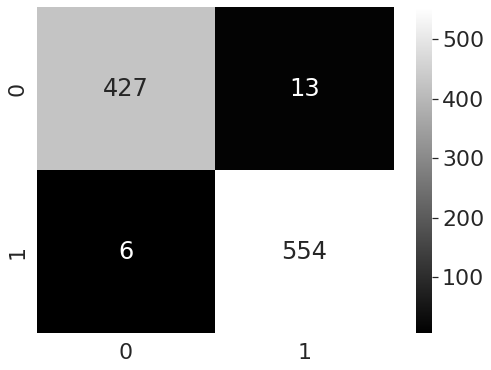

In [29]:
import seaborn as sns
confusion_matrix = get_clf_eval(test_labels,y_pred,y_pred)
plt.figure(figsize=(8,6))
sns.set(font_scale = 2)
sns.set_style("white")
sns.heatmap(confusion_matrix, cmap = 'gist_yarg_r',annot = True, fmt='d')

In [19]:
!pip install tf2onnx
!pip install keras2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.3/442.3 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.9 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
Looking in indexes: https://pypi.org/simpl

In [30]:
# loading whole model
from keras.models import load_model
modelkeras = keras.models.load_model("autoencoder_model.h5")
tf.saved_model.save(modelkeras, "tmp_model")

In [34]:
print(modelkeras.predict(test_data))

32/32 [==============================] - 0s 3ms/step
[[0.00569243 0.9943076 ]
 [0.5340934  0.46590656]
 [0.00769142 0.9923086 ]
 ...
 [0.00849165 0.99150836]
 [0.01337029 0.9866298 ]
 [0.00720236 0.9927977 ]]


In [22]:
!python3 -m tf2onnx.convert --saved-model tmp_model --output "rpmodel.onnx"

2023-02-19 00:35:35.554211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 00:35:35.554382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 00:35:35.554411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package